In [1]:
from helper_functions import unzip_data, plot_loss_curves, compare_historys, make_confusion_matrix, create_tensorboard_callback

In [2]:
# use tensorflow datasets to download data
import tensorflow_datasets as tfds

In [3]:
# list all available datasets
datasets_list = tfds.list_builders()
print('food101' in datasets_list)

True


In [4]:
(train_data, test_data), ds_info = tfds.load(
    name='food101',
    split=['train', 'validation'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2021-12-29 17:39:30.581537: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-29 17:39:30.581648: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [6]:
# get the class names
class_names = ds_info.features['label'].names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [7]:
# explore more
# take one sample of the train data
train_data

<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [8]:
train_one_sample = train_data.take(1)
train_one_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [9]:
# output info about out training sample
for image, label in train_one_sample:
    print(f"""
    Image shape: {image.shape}
    Image datatype: {image.dtype}
    Target class from food101 (tensor form): {label}
    Class name (str form): {class_names[label.numpy()]}
    """)


    Image shape: (512, 512, 3)
    Image datatype: <dtype: 'uint8'>
    Target class from food101 (tensor form): 42
    Class name (str form): french_toast
    


2021-12-29 17:39:30.724248: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-29 17:39:30.724395: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [10]:
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[199, 219, 228],
        [202, 222, 231],
        [202, 222, 229],
        ...,
        [ 54,  54,  54],
        [ 48,  48,  50],
        [ 45,  45,  47]],

       [[205, 225, 234],
        [213, 233, 240],
        [220, 240, 247],
        ...,
        [ 53,  53,  53],
        [ 47,  47,  49],
        [ 44,  44,  46]],

       [[208, 228, 235],
        [219, 239, 246],
        [231, 251, 255],
        ...,
        [ 53,  53,  53],
        [ 47,  47,  47],
        [ 42,  42,  42]],

       ...,

       [[127, 138, 144],
        [125, 136, 142],
        [122, 133, 139],
        ...,
        [167, 177, 179],
        [167, 177, 179],
        [167, 177, 179]],

       [[129, 140, 146],
        [127, 138, 144],
        [124, 135, 141],
        ...,
        [167, 175, 178],
        [168, 176, 179],
        [169, 177, 180]],

       [[131, 142, 148],
        [128, 139, 145],
        [126, 137, 143],
        ...,
        [167, 175, 17

In [11]:
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

Text(0.5, 1.0, 'french_toast')

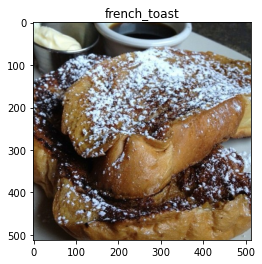

In [12]:
# plot a image
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])

In [13]:
def preprocess_img(image, label, img_shape=224):
    """
    convert shape and dtype
    """
    image = tf.image.resize(image, [img_shape, img_shape])
    return tf.cast(image, tf.float32), label

In [14]:
preprocesed_img = preprocess_img(image, label)[0]
print(f"image before preprocessing:\n{image[:2]}...,\nshape: {image.shape},\ndatatype:{image.dtype}\n")
print(f"image before preprocessing:\n{preprocesed_img[:2]}...,\nshape: {preprocesed_img.shape},\ndatatype:{preprocesed_img.dtype}\n")

image before preprocessing:
[[[199 219 228]
  [202 222 231]
  [202 222 229]
  ...
  [ 54  54  54]
  [ 48  48  50]
  [ 45  45  47]]

 [[205 225 234]
  [213 233 240]
  [220 240 247]
  ...
  [ 53  53  53]
  [ 47  47  49]
  [ 44  44  46]]]...,
shape: (512, 512, 3),
datatype:<dtype: 'uint8'>

image before preprocessing:
[[[206.85204  226.85204  235.02551 ]
  [210.05612  230.9847   236.12755 ]
  [200.83673  221.83673  223.39796 ]
  ...
  [ 62.785736  63.        60.35721 ]
  [ 58.596867  58.596867  58.596867]
  [ 46.28561   46.28561   48.28561 ]]

 [[213.54591  234.14285  239.94899 ]
  [233.65306  254.64795  255.      ]
  [223.42857  245.35715  243.57143 ]
  ...
  [ 65.500046  65.71431   63.071518]
  [ 60.49482   60.49482   60.49482 ]
  [ 46.47435   46.47435   46.47435 ]]]...,
shape: (224, 224, 3),
datatype:<dtype: 'float32'>



In [15]:
# map preprocessing function to train data and parrelize
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# shuffle train data and turn it into batches
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(tf.data.AUTOTUNE)
# map preprocessing function to test data
test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [16]:
train_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

In [17]:
# create modeling callbacks
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from helper_functions import create_tensorboard_callback

In [18]:
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
    )
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    min_delta=0.005,
    patience=1
)

In [19]:
# set up mixed precision training (m1 doesn't support yet)
#from tensorflow.keras import mixed_precision
#mixed_precision.set_global_policy('mixed_float16')

In [20]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB4
from tensorflow.keras import Sequential, Model
from tensorflow.keras.optimizers import Adam

input_shape = (224, 224, 3)
#base_model = EfficientNetB0(include_top=False)
base_model = EfficientNetB4(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=input_shape, name='input_layer')
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name='global_avg_pooling')(x)
#x = layers.Dense(len(class_names))(x)
#outputs = layers.Activation('softmax', dtype=tf.float32)(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)
model = Model(inputs, outputs)

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy'],
)

71696384/71686520 [==============================] - 3s 0us/step


In [21]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb4 (Functional)  (None, None, None, 1792)  17673823  
_________________________________________________________________
global_avg_pooling (GlobalAv (None, 1792)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               181093    
Total params: 17,854,916
Trainable params: 181,093
Non-trainable params: 17,673,823
_________________________________________________________________


In [22]:
for layer in model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb4 False float32 <Policy "float32">
global_avg_pooling True float32 <Policy "float32">
dense True float32 <Policy "float32">


In [23]:
hsitory_teature_extraction = model.fit(
    train_data,
    epochs=100,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=int(0.15 * len(test_data)),
    callbacks=[
        early_stopping,
        model_checkpoint,
        create_tensorboard_callback(
            dir_name='training_logs',
            experiment_name='efficientnetb4_101_class_full_data'
    )]
)

Saving TensorBoard log files to: training_logs/efficientnetb4_101_class_full_data/20211229-173936
Epoch 1/100


2021-12-29 17:39:36.576612: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 17:39:36.576618: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-29 17:39:36.576698: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
/Users/skyler/miniforge3/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
2021-12-29 17:39:39.151461: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


   2/2368 [..............................] - ETA: 9:32 - loss: 4.6244 - accuracy: 0.0156       

2021-12-29 17:39:41.002607: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 17:39:41.002618: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-29 17:39:41.129901: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-12-29 17:39:41.131922: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-29 17:39:41.134203: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: training_logs/efficientnetb4_101_class_full_data/20211229-173936/train/plugins/profile/2021_12_29_17_39_41

2021-12-29 17:39:41.135816: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to training_logs/efficientnetb4_101_class_full_data/20211229-173936/train/plugins/profile/2021_12_29_17_39_41/Sikuns-MacBook-Pro.local.trace.json.gz
2021-12-29 17:39:41.137033: I tensorflow/core/profil

2368/2368 [==============================] - ETA: 0s - loss: 1.8689 - accuracy: 0.5374

2021-12-29 17:44:26.096249: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2368/2368 [==============================] - 305s 127ms/step - loss: 1.8689 - accuracy: 0.5374 - val_loss: 1.3409 - val_accuracy: 0.6457

Epoch 00001: val_accuracy improved from -inf to 0.64566, saving model to model_checkpoints/cp.ckpt
Epoch 2/100
2368/2368 [==============================] - 299s 126ms/step - loss: 1.3868 - accuracy: 0.6396 - val_loss: 1.2406 - val_accuracy: 0.6724

Epoch 00002: val_accuracy improved from 0.64566 to 0.67240, saving model to model_checkpoints/cp.ckpt
Epoch 3/100
2368/2368 [==============================] - 299s 126ms/step - loss: 1.2379 - accuracy: 0.6765 - val_loss: 1.1993 - val_accuracy: 0.6796

Epoch 00003: val_accuracy improved from 0.67240 to 0.67956, saving model to model_checkpoints/cp.ckpt
Epoch 4/100
2368/2368 [==============================] - 300s 126ms/step - loss: 1.1376 - accuracy: 0.6997 - val_loss: 1.1865 - val_accuracy: 0.6841

Epoch 00004: val_accuracy improved from 0.67956 to 0.68406, saving model to model_checkpoints/cp.ckpt


In [24]:
results_feature_extraction = model.evaluate(test_data)

790/790 [==============================] - 96s 122ms/step - loss: 1.1816 - accuracy: 0.6822


In [25]:
model.save("food_vision_big_effnetb4_feature_extraction_model")

2021-12-29 18:01:24.083037: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: food_vision_big_effnetb4_feature_extraction_model/assets


INFO:tensorflow:Assets written to: food_vision_big_effnetb4_feature_extraction_model/assets
/Users/skyler/miniforge3/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [26]:
loaded_model = tf.keras.models.load_model("food_vision_big_effnetb4_feature_extraction_model")

In [27]:
loaded_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb4 (Functional)  (None, None, None, 1792)  17673823  
_________________________________________________________________
global_avg_pooling (GlobalAv (None, 1792)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               181093    
Total params: 17,854,916
Trainable params: 181,093
Non-trainable params: 17,673,823
_________________________________________________________________


In [28]:
loaded_model.evaluate(test_data)

2021-12-29 18:01:46.940891: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


790/790 [==============================] - 101s 124ms/step - loss: 1.1816 - accuracy: 0.6822


[1.1816288232803345, 0.6822178363800049]

In [29]:
for layer in loaded_model.layers:
    print(layer.trainable)

True
False
True
True


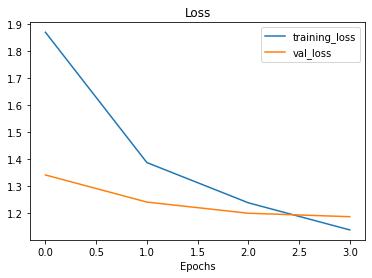

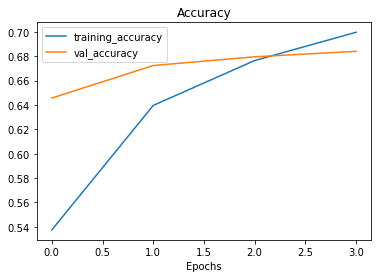

In [30]:
plot_loss_curves(hsitory_teature_extraction)

In [31]:
loaded_model.trainable = True
loaded_model.layers[1].trainable = True

In [32]:
for layer in loaded_model.layers[1].layers:
    print(layer.trainable)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [33]:
loaded_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb4 (Functional)  (None, None, None, 1792)  17673823  
_________________________________________________________________
global_avg_pooling (GlobalAv (None, 1792)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               181093    
Total params: 17,854,916
Trainable params: 17,729,709
Non-trainable params: 125,207
_________________________________________________________________


In [34]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    mode='min',
    min_delta=0.05,
    patience=1
)

checkpoint_path = "model_checkpoints_fine_tuning/cp.ckpt"
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True
)

In [35]:
loaded_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

In [36]:
for layer in loaded_model.layers[1].layers:
    print(layer.trainable)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [37]:
history_fine_tuning = loaded_model.fit(
    train_data,
    epochs=100,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=int(0.15 * len(test_data)),
    callbacks=[
        early_stopping,
        model_checkpoint,
        create_tensorboard_callback(
            dir_name='training_logs',
            experiment_name='efficientnetb4_101_class_full_data_fine_tuning'
        )
        ]
)

Saving TensorBoard log files to: training_logs/efficientnetb4_101_class_full_data_fine_tuning/20211229-180327
Epoch 1/100


2021-12-29 18:03:27.032559: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 18:03:27.032566: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-12-29 18:03:27.032653: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-29 18:03:30.151965: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


   1/2368 [..............................] - ETA: 8:56:41 - loss: 1.1518 - accuracy: 0.6875

2021-12-29 18:03:40.877309: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-12-29 18:03:40.877324: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


   2/2368 [..............................] - ETA: 2:20:18 - loss: 1.0775 - accuracy: 0.7344

2021-12-29 18:03:44.741309: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-12-29 18:03:44.743979: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-12-29 18:03:44.745993: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: training_logs/efficientnetb4_101_class_full_data_fine_tuning/20211229-180327/train/plugins/profile/2021_12_29_18_03_44

2021-12-29 18:03:44.748306: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to training_logs/efficientnetb4_101_class_full_data_fine_tuning/20211229-180327/train/plugins/profile/2021_12_29_18_03_44/Sikuns-MacBook-Pro.local.trace.json.gz
2021-12-29 18:03:44.750257: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: training_logs/efficientnetb4_101_class_full_data_fine_tuning/20211229-180327/train/plugins/profile/2021_12_29_18_03_44

2021-12-29 18:03:44.750579

2368/2368 [==============================] - ETA: 0s - loss: 0.8999 - accuracy: 0.7547

2021-12-29 18:23:27.661421: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2368/2368 [==============================] - 1218s 509ms/step - loss: 0.8999 - accuracy: 0.7547 - val_loss: 0.7318 - val_accuracy: 0.7987
Epoch 2/100
2368/2368 [==============================] - 1196s 505ms/step - loss: 0.3694 - accuracy: 0.8952 - val_loss: 0.7269 - val_accuracy: 0.8083


In [38]:
loaded_model.evaluate(test_data)

790/790 [==============================] - 98s 124ms/step - loss: 0.7487 - accuracy: 0.8017


[0.7486677169799805, 0.8017426133155823]

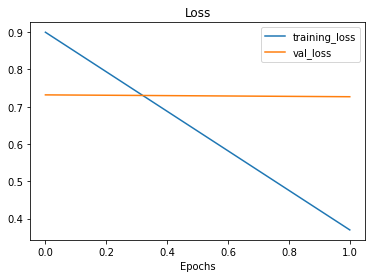

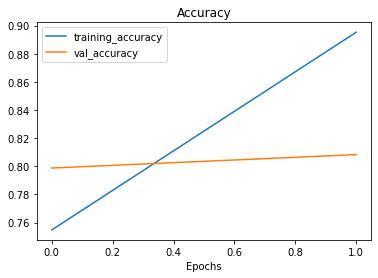

In [39]:
plot_loss_curves(history_fine_tuning)

In [40]:
model.save("food_vision_big_effnetb4_fine_tuning_model")

INFO:tensorflow:Assets written to: food_vision_big_effnetb4_fine_tuning_model/assets


INFO:tensorflow:Assets written to: food_vision_big_effnetb4_fine_tuning_model/assets
/Users/skyler/miniforge3/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
